# Titanic Project Example Walk Through


Welcome to this Titanic project. This is my first kernel at Kaggle. In this notebook, I'm going to predict wether a passenger of the famous boat will survive or not. Firstly, I will display some feature analyses then ill focus on the feature engineering. Last part concerns modeling and predicting the survival on the Titanic using an voting procedure. If you find a way to improve it I encourage you to fork this notebook and contribute by adding a better solution. 

# Import libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import data viz libraires
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#import algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

from IPython.display import display


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Data Exploration

In [2]:
train_raw = pd.read_csv("/kaggle/input/titanic/train.csv")
test_raw = pd.read_csv("/kaggle/input/titanic/test.csv")

train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train= train_raw
test= test_raw
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We can see that some of the features have missing values. We need to examine the features that have missing values and the percnetage of the missing values so we can deal with those. Let's take a look.  

In [5]:
#find percent of missing data
percent_missing = train.isnull().sum() *100 /len(train)
percent_missing = percent_missing.sort_values(ascending=False)
percent_missing

Cabin          77.104377
Age            19.865320
Embarked        0.224467
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
dtype: float64

The Embarked feature has only 2 missing values, which can easily be filled. It will be much more tricky, to deal with the ‘Age’ and 'Cabin' features, which have 19% and 77% missing values. We wil deal with them later on in feature engineering section.

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

# Understanding Data with plots

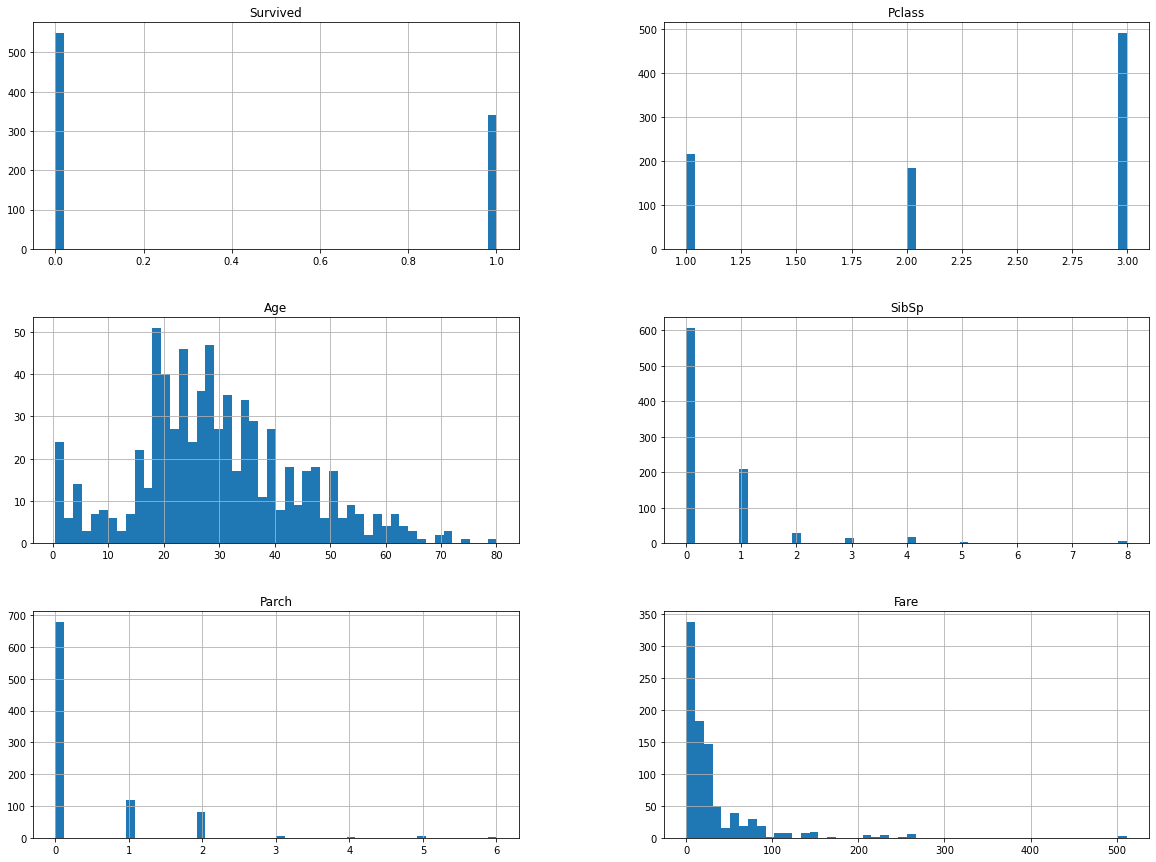

In [8]:
#plot histograms for all variables
#first we need to drop passenger id
train.drop(['PassengerId'], 1).hist(bins=50, figsize=(20,15))
plt.show()

<AxesSubplot:>

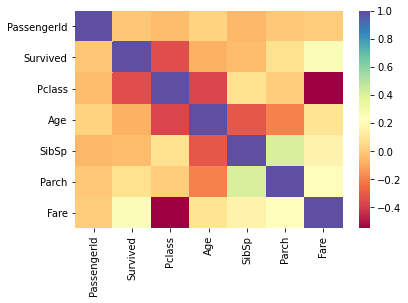

In [9]:
train.corr()
sns.heatmap(train.corr(), cmap='Spectral')

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

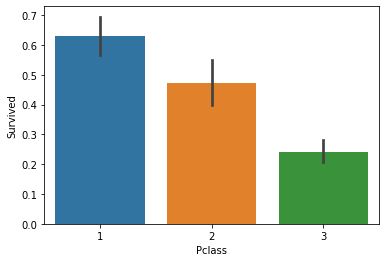

In [10]:
#see effect of class on survival rate
sns.barplot(x='Pclass', y='Survived', data=train)

Here we see clearly, that Pclass is contributing to a persons chance of survival, especially if this person is in class 1.

In [11]:
pd.pivot_table(train, index = 'Survived', values = ['Age','SibSp','Parch','Fare', 'Pclass'])

,Age,Fare,Parch,Pclass,SibSp
Survived,,,,,
0,30.626179,22.117887,0.329690,2.531876,0.553734
1,28.343690,48.395408,0.464912,1.950292,0.473684


In [12]:
# Comparing survival and each of these categorical variables 
print(pd.pivot_table(train, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(train, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(train, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


With this first exploration, we can see that :
* Only aproximately 35% of passengers survived 
* More than the half of passengers are in the lowest class (pclass = 3)
* Most of the fare tickets are below 50
* Majority of passengers are alone (sibsp and parch)

 # Data Pre processing

First, let's drop PassengerId from the train set, because it does not contribute to a persons survival probability. I'll keep it in the test set, since it is required for submission.

In [13]:
train= train.drop(['PassengerId'], axis=1)

# Missing Data 

Next drop null values from Embarked (only 2 values). 
Below is the distribution of Embarked according to Fare and sex, and the two observations with missing "Embarked" value. Let's look at there two observations and choose the best matching embarked value according to their fare value and sex


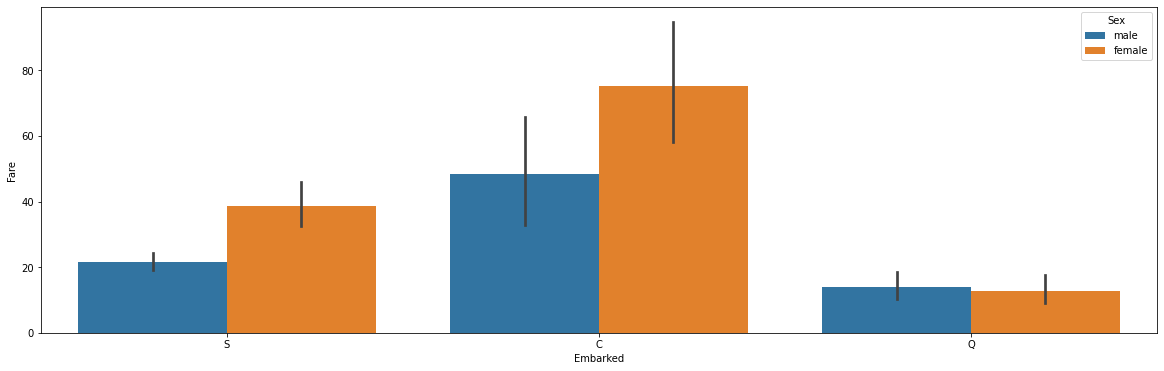

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [14]:
figure, axes = plt.subplots(1,1,figsize=(20, 6))
plot = sns.barplot(x="Embarked", y="Fare", hue="Sex", data=train, ax=axes)
plt.show()
display(train[train['Embarked'].isnull()])

Both passengers are female who paid 80 dollars as fare for their tickets. They have the same ticket and cabin, so they probably had to board at the same place. According to the distribution above, the more probable embarked value for them is Cherbourg (C). Let's replace it with C. 

In [15]:
def data_preprocessing(df):
# use this function to process both training and testing data

    processed_df= df
    #replace emabrked with C
    processed_df['Embarked'].fillna('C', inplace=True)


    # replace missing ages by the mean age of passengers who belong to the same group of class/sex/family
    processed_df['Age'] = processed_df.groupby(['Pclass','Sex','Parch','SibSp'])['Age'].transform(lambda x: x.fillna(x.mean()))   
    processed_df['Age'] = processed_df.groupby(['Pclass','Sex','Parch'])['Age'].transform(lambda x: x.fillna(x.mean()))
    processed_df['Age'] = processed_df.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.mean()))
    
    # replace the only missing fare value for test dataset 
    processed_df['Fare'] = processed_df['Fare'].interpolate()    
    
    return processed_df

In [16]:
train = data_preprocessing(train)
test = data_preprocessing(test)

# Feature Engineering

A cabin number looks like ‘C123’ and the letter refers to the deck. Therefore we’re going to extract these and create a new feature, that contains a persons deck. We will then convert the feature into a numeric variable. The missing values will be converted to zero. 
Using SibSp and Parch, new features 'number of relatives' and 'not_alone' are created. 
We will use the Name feature to extract the Titles from the Name, so that we can build a new feature out of that.

In [17]:
import re

deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train, test]

for dataset in data:
    # Modification of cabin column to keep only the letter contained corresponding to the deck of the boat

    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
    
    #calculate feature that shows number of relatives on the ship 

    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)

    # Create a Title column from name column
    dataset['Title'] = pd.Series((name.split('.')[0].split(',')[1].strip() for name in dataset['Name']), index=dataset.index)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace(['Mlle', 'Ms'], 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})


In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   Name       891 non-null    object 
 3   Sex        891 non-null    object 
 4   Age        891 non-null    float64
 5   SibSp      891 non-null    int64  
 6   Parch      891 non-null    int64  
 7   Ticket     891 non-null    object 
 8   Fare       891 non-null    float64
 9   Cabin      891 non-null    object 
 10  Embarked   891 non-null    object 
 11  Deck       891 non-null    int64  
 12  relatives  891 non-null    int64  
 13  not_alone  891 non-null    int64  
 14  Title      891 non-null    int64  
dtypes: float64(2), int64(8), object(5)
memory usage: 104.5+ KB


We have four features that are categorical in nature (Dtype object) and fare is float type. We need to transform our variables. We will drop features that we do not need anymore.

In [19]:
# Transform categorical variables to numeric variables
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
train['Embarked'] = train['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

test['Sex'] = test['Sex'].map({'male': 0, 'female': 1})
test['Embarked'] = test['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

#convert Fare and Age from flaot to integer type
cols = ['Fare', 'Age']
train[cols] = train[cols].fillna(0)
test[cols] = test[cols].fillna(0)

train[cols] = train[cols].applymap(np.int64)
test[cols] = test[cols].applymap(np.int64)

#drop name, ticket  and cabin from the dataset
train = train.drop(['Name', 'Ticket', 'Cabin'], axis=1)
test = test.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Survived   891 non-null    int64
 1   Pclass     891 non-null    int64
 2   Sex        891 non-null    int64
 3   Age        891 non-null    int64
 4   SibSp      891 non-null    int64
 5   Parch      891 non-null    int64
 6   Fare       891 non-null    int64
 7   Embarked   891 non-null    int64
 8   Deck       891 non-null    int64
 9   relatives  891 non-null    int64
 10  not_alone  891 non-null    int64
 11  Title      891 non-null    int64
dtypes: int64(12)
memory usage: 83.7 KB


# Scaling Dataset

In [21]:
from sklearn.model_selection import train_test_split

X = train.drop(['Survived'], 1)
Y = train['Survived']

#scale data because we need all variables to be on the same scale when paing to the model
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X.values), index=X.index, columns=X.columns)
    
# Split dataset for model testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,relatives,not_alone,Title
331,-1.566107,-0.737695,1.150861,-0.474545,-0.473674,-0.076207,-0.571933,-1.898603,-0.560975,0.811922,-0.707550
733,-0.369365,-0.737695,-0.476550,-0.474545,-0.473674,-0.378164,-0.571933,0.513224,-0.560975,0.811922,-0.707550
382,0.827377,-0.737695,0.189209,-0.474545,-0.473674,-0.498948,-0.571933,0.513224,-0.560975,0.811922,-0.707550
704,0.827377,-0.737695,-0.254631,0.432793,-0.473674,-0.498948,-0.571933,0.513224,0.059160,-1.231645,-0.707550
813,0.827377,1.355574,-1.734095,3.154809,2.008933,-0.015815,-0.571933,0.513224,3.159833,-1.231645,0.263832


# Modeling 


Trying several models

# Logistic Regression
We'll start with logistic regression because it is one of the simplest and most basic model used for testing. 

In [22]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
print(acc_log)

81.88


# K Nearest Neighbor

In [23]:
# KNN 
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, Y_train)  
Y_pred = knn.predict(X_test)  
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
print(acc_knn)

88.06


# Gaussain Naive Bayes

In [24]:
gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  
Y_pred = gaussian.predict(X_test)  
acc_gauss = round(gaussian.score(X_train, Y_train) * 100, 2)
print(acc_gauss)

79.07


# Linear Support Vector Machine


In [25]:
from sklearn.svm import SVC

SVMC = SVC(probability=True, kernel='rbf')
SVMC.fit(X_train, Y_train)

Y_pred = SVMC.predict(X_test)

acc_svc = round(SVMC.score(X_train, Y_train) * 100, 2)
print(acc_svc)

84.83


# Decision Tree

In [26]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train)  
Y_pred = decision_tree.predict(X_test)  
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
print(acc_decision_tree)

96.77


# Random Forest

In [27]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

print(acc_random_forest)

96.77


# XGBoost

In [28]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)

xgb.fit(X_train, Y_train)

y_pred = xgb.predict(X_test)
acc_xgb = round(xgb.score(X_train, Y_train) * 100, 2)
print(acc_xgb)

[16:50:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
95.79


# Finding the best model 


In [29]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'XGBoost', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, acc_random_forest, acc_gauss, acc_xgb,acc_decision_tree]})

result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(7)

,Model
Score,
96.77,Random Forest
96.77,Decision Tree
95.79,XGBoost
88.06,KNN
84.83,Support Vector Machines
81.88,Logistic Regression
79.07,Naive Bayes


As expected, random forest outperforms all of the other algorithms while naive baes is at bottom of the list. 

# Finding the best model using k-folds cross validation 
The above results are the baseline scores and they could be probaby be improved with cross validation method, which consists of dividing the training set in k parts (folds) and evaluating k times using successively each part as the test set and the 9 other parts as the training set. Therefore, we can compute a mean error over the 10 trainings of our model.  Cross validation will verify which model has the best accuracy over several training steps. 
Let's find out which algorithm performs better. 

In [30]:
from sklearn.model_selection import cross_val_score

n_folds = 5
cv_score_lg = cross_val_score(estimator=logreg, X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)
cv_score_dt = cross_val_score(estimator=decision_tree, X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)
cv_score_svm = cross_val_score(estimator=SVMC, X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)
cv_score_rf = cross_val_score(estimator=random_forest, X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)
cv_score_xgb = cross_val_score(estimator=xgb, X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)
cv_score_nb = cross_val_score(estimator=gaussian, X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)
cv_score_knn = cross_val_score(estimator=knn, X=X_train, y=Y_train, cv=n_folds, n_jobs=-1)

In [31]:
cv_result = {'lg': cv_score_lg, 'dt': cv_score_dt, 'svm': cv_score_svm, 'rf': cv_score_rf, 
             'XGB': cv_score_xgb,'NB': cv_score_nb , 'knn': cv_score_knn}
cv_data = {model: [score.mean(), score.std()] for model, score in cv_result.items()}
cv_df = pd.DataFrame(cv_data, index=['Mean_accuracy', 'Variance'])
cv_df

,lg,dt,svm,rf,XGB,NB,knn
Mean_accuracy,0.811770,0.773860,0.832798,0.803368,0.807564,0.773771,0.811790
Variance,0.021765,0.019772,0.022865,0.018346,0.011719,0.034880,0.013748


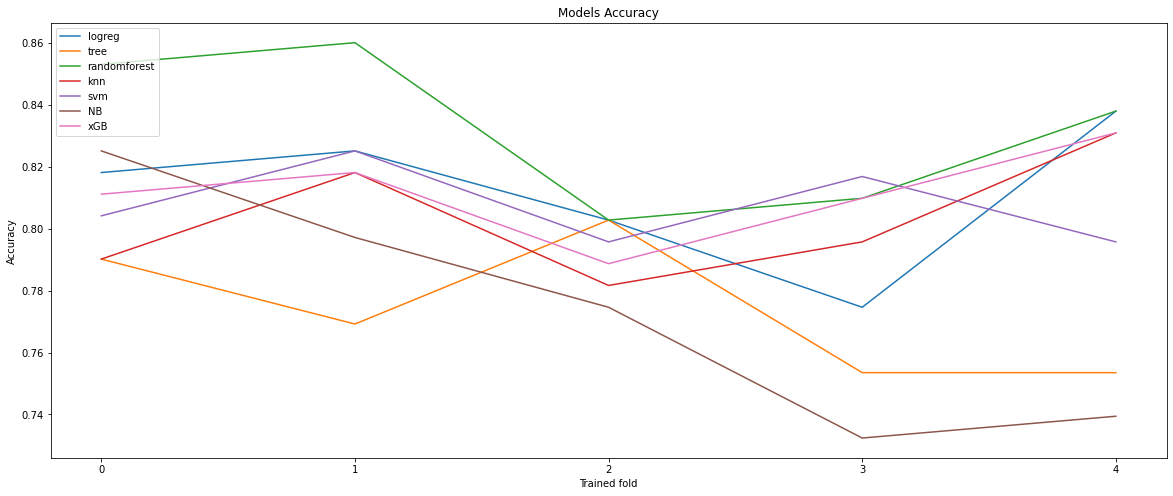

In [32]:
plt.figure(figsize=(20,8))
plt.plot(cv_result['lg'])
plt.plot(cv_result['dt'])
plt.plot(cv_result['svm'])
plt.plot(cv_result['rf'])
plt.plot(cv_result['XGB'])
plt.plot(cv_result['NB'])
plt.plot(cv_result['knn'])


plt.title('Models Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Trained fold')
plt.xticks([k for k in range(n_folds)])
plt.legend(['logreg', 'tree', 'randomforest', 'knn', 'svm','NB', 'xGB'], loc='upper left')
plt.show()

All models seems to have a good accuracy and nearly the same variance, it seems that there is no "best model". From this I cannot conclude which model performs best because te differene is very little. 
To improve the performance we could also do some sort of ensemble learning. Let's try that.

# Ensemble Learning

Ensembling is the technique of combining differnet classifiers to improve the accuracy of a model. It alsi helps in diminushing the variance of our model making it more reliable. So basically ensembling/combining two or more algorithms could improve or boost your performance.

I decided to use the SVC, xGBoost, random forest, knn for the ensemble learning.
I chose a voting classifier to combine the predictions coming from the 4 classifiers.
I exerimented with both the 'soft' and 'hard' voting parameter. I've also experimented withh all classifiers. 

In [33]:
from sklearn.ensemble import VotingClassifier

voting_hard = VotingClassifier(estimators = [('knn',knn),('rf',random_forest),('svc',SVMC),
                                            ('xGB', xgb)], voting = 'hard') 
voting_soft = VotingClassifier(estimators = [('knn',knn),('rf',random_forest),('svc',SVMC),
                                            ('xGB', xgb)], voting = 'soft') 

voting_all_soft = VotingClassifier(estimators = [('knn',knn),('rf',random_forest),('svc',SVMC),
                                            ('xGB', xgb), ('DT', decision_tree), ('LogReg', logreg),
                                          ('NB', gaussian)], voting = 'soft')

voting_all_hard = VotingClassifier(estimators = [('knn',knn),('rf',random_forest),('svc',SVMC),
                                            ('xGB', xgb), ('DT', decision_tree), ('LogReg', logreg),
                                          ('NB', gaussian)], voting = 'hard')
score={}

score['voting_hard:'] = (cross_val_score(voting_hard,X_train,Y_train,cv=n_folds))
score['voting_hard mean:']= (cross_val_score(voting_hard,X_train,Y_train,cv=n_folds).mean())

score['voting_soft :']=(cross_val_score(voting_soft,X_train,Y_train,cv=n_folds))
score['voting_soft mean :']=(cross_val_score(voting_soft,X_train,Y_train,cv=n_folds).mean())

score['voting_all_soft :']=(cross_val_score(voting_all_soft,X_train,Y_train,cv=n_folds))
score['voting_all_soft mean :']=(cross_val_score(voting_all_soft,X_train,Y_train,cv=n_folds).mean())

score['voting_all_hard :']=(cross_val_score(voting_all_hard,X_train,Y_train,cv=n_folds))
score['voting_all_hard mean :']=(cross_val_score(voting_all_hard,X_train,Y_train,cv=n_folds).mean())

[16:51:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

# Results

In [34]:
# print each data item. 
for key, value in score.items(): 
    print ("{} {}".format(key, value))

voting_hard: [0.83216783 0.83216783 0.79577465 0.80985915 0.85211268]
voting_hard mean: 0.8272234807446075
voting_soft : [0.82517483 0.83916084 0.80985915 0.82394366 0.84507042]
voting_soft mean : 0.8300403821530582
voting_all_soft : [0.83216783 0.83916084 0.80985915 0.81690141 0.83098592]
voting_all_soft mean : 0.8258051807347583
voting_all_hard : [0.85314685 0.83916084 0.80985915 0.80985915 0.82394366]
voting_all_hard mean : 0.8314192849404115


In [35]:
# scale test dataset
test.drop(labels = ["PassengerId"], axis = 1, inplace = True)

test = pd.DataFrame(sc.fit_transform(test.values), index=test.index, columns=test.columns)

In [36]:
test.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,relatives,not_alone,Title
0,0.873482,-0.755929,0.348138,-0.499470,-0.400248,-0.504085,2.243165,0.500456,-0.553443,0.807573,-0.738020
1,0.873482,1.322876,1.348023,0.616992,-0.400248,-0.504085,-0.677841,0.500456,0.105643,-1.238278,1.252253
2,-0.315819,-0.755929,2.501737,-0.499470,-0.400248,-0.468238,2.243165,0.500456,-0.553443,0.807573,-0.738020
3,0.873482,-0.755929,-0.190262,-0.499470,-0.400248,-0.486162,-0.677841,0.500456,-0.553443,0.807573,-0.738020
4,0.873482,1.322876,-0.574833,0.616992,0.619896,-0.414468,-0.677841,0.500456,0.764728,-1.238278,1.252253
5,0.873482,-0.755929,-1.190147,-0.499470,-0.400248,-0.468238,-0.677841,0.500456,-0.553443,0.807573,-0.738020
6,0.873482,1.322876,0.040481,-0.499470,-0.400248,-0.504085,2.243165,0.500456,-0.553443,0.807573,0.257117
7,-0.315819,-0.755929,-0.267176,0.616992,0.619896,-0.109770,-0.677841,0.500456,0.764728,-1.238278,-0.738020
8,0.873482,1.322876,-0.882490,-0.499470,-0.400248,-0.504085,0.782662,0.500456,-0.553443,0.807573,1.252253
9,0.873482,-0.755929,-0.651747,1.733455,-0.400248,-0.199387,-0.677841,0.500456,0.764728,-1.238278,-0.738020


In [37]:
#fit models
voting_hard.fit(X_train,Y_train)
voting_soft.fit(X_train,Y_train)
voting_all_soft.fit(X_train,Y_train)
voting_all_hard.fit(X_train,Y_train)

# Predict for test data sample
pred_hard=voting_hard.predict(test)
pred_soft=voting_soft.predict(test)
pred_allsoft=voting_all_soft.predict(test)
pred_allhard=voting_all_hard.predict(test)

#convert output to dataframe 
final_data = {'PassengerId': test_raw.PassengerId, 'Survived': pred_hard}
submission = pd.DataFrame(data=final_data)

final_data_2 = {'PassengerId': test_raw.PassengerId, 'Survived': pred_soft}
submission_2 = pd.DataFrame(data=final_data_2)

final_data_3 = {'PassengerId': test_raw.PassengerId, 'Survived': pred_allsoft}
submission_3 = pd.DataFrame(data=final_data_3)

final_data_4 = {'PassengerId': test_raw.PassengerId, 'Survived': pred_allhard}
submission_4 = pd.DataFrame(data=final_data_4)

#convert to csv
submission.to_csv('Hard Voting.csv', index =False)
submission_2.to_csv('Soft Voting.csv',index=False)
submission_3.to_csv('soft_all.csv', index=False)
submission_4.to_csv('hard_all.csv', index=False)

[16:51:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [38]:
submission_4.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


Thank you for your reading, feel free to fork this kernel and improve it. There is still room for improvement, like doing a more extensive feature engineering, by comparing and plotting the features against each other and identifying and removing the noisy features. Another thing that can improve the overall result on the kaggle leaderboard would be a more extensive hyperparameter tuning on several machine learning models.

If you found this notebook helpful or you just liked it , some upvotes would be very much appreciated.